Set Animal IDs and Experiment IDs

In [9]:
data_path = "/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Mapping_Through_Skull/"

exp_info = {
            "ctb01": {"exp_name": "20220603_101509", "rearing": "DR"},
            "ctb02": {"exp_name": "20220610_105811", "rearing": "DR"},
            "ctb07": {"exp_name": "20220711_135556", "rearing": "DR"},
            "ctb08": {"exp_name": "20220715_121356", "rearing": "DR"},
            "lt168": {"exp_name": "20220330_130327", "rearing": "DR"},
            "lt169": {"exp_name": "20220420_125809", "rearing": "DR"},
            "lt170": {"exp_name": "20220421_133932", "rearing": "DR"},
            "ctb03": {"exp_name": "20220623_161247", "rearing": "NR"},
            "ctb04": {"exp_name": "20220630_130119", "rearing": "NR"},
            "ctb05": {"exp_name": "20220706_105937", "rearing": "NR"},
            "ctb09": {"exp_name": "20220720_153020", "rearing": "NR"},
            "lt164": {"exp_name": "20220302_131952", "rearing": "NR"},
            "lt171": {"exp_name": "20220427_115917", "rearing": "NR"},
            "lt172": {"exp_name": "20220428_130342", "rearing": "NR"},
            "lt175": {"exp_name": "20220512_124014", "rearing": "NR"}
            }

Get User Input for Visual Area Boundaries on Sign Maps

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread
from os.path import exists

# Choose visual areas for segmentation.
area_list = ["V1", "LM", "AL", "RL", "AM", "PM", "M"]

%matplotlib qt5
for ID,data in exp_info.items():
    # Load reference frame and sign map for segmenting
    exp_path = data_path + "{a}//{e}//".format(a=ID, e=data["exp_name"])
    data["refframe"] = imread(exp_path + "refframe.tif").squeeze()
    data["signmap"] = np.loadtxt(exp_path + "signmap.csv")
    # Create dictionary for storing visual area boundary coordinates.
    data["area_coords"] = dict(zip(area_list, [None]*len(area_list)))
    for area_num,area in enumerate(area_list):
        fig, ax = plt.subplots()
        ax.imshow(data["refframe"], cmap="gray")
        ax.imshow(data["signmap"], cmap="RdBu_r", clim=[-1,1], alpha=0.3)
        # Plot previously segmented areas to avoid selecting overlapping regions.
        if area_num > 0:
            for prev_area in area_list[:area_num]:
                ax.plot(data["area_coords"][prev_area][:,0], data["area_coords"][prev_area][:,1], color="k", linewidth=3)
        ax.set_title("Select Region for {ar}:".format(ar=area), fontsize=20)
        ax.axis("off")
        fig.set_size_inches(12, 12)
        # If segmentation coordinates are already saved for this area, use those.
        # Otherwise, get user input.
        if exists(exp_path + "{ar}.csv".format(ar=area)):
            data["area_coords"][area] = np.loadtxt(exp_path + "{ar}.csv".format(ar=area))
        else:
            curr_input = plt.ginput(n=-1, timeout=-1)
            curr_input = np.array(curr_input)
            curr_input = np.append(curr_input, [curr_input[0,:]], axis=0)
            data["area_coords"][area] = curr_input
            np.savetxt(exp_path + "{ar}.csv".format(ar=area), curr_input)
        plt.close()
    # Also load average magnitude, azimuth, and elevation data for downstream analyses.
    data["avg_mag"] = np.loadtxt(exp_path + "avg_mag.csv")
    nan_idx = (tuple(np.where(np.isnan(data["signmap"]))[0]), tuple(np.where(np.isnan(data["signmap"]))[1]))
    np.add.at(data["avg_mag"], nan_idx, np.nan)
    data["azimuth"] = np.loadtxt(exp_path + "azimuth.csv")
    data["elevation"] = np.loadtxt(exp_path + "elevation.csv")

Plot Sign Map, Boundaries + Magnitude, Azimuth, and Elevation

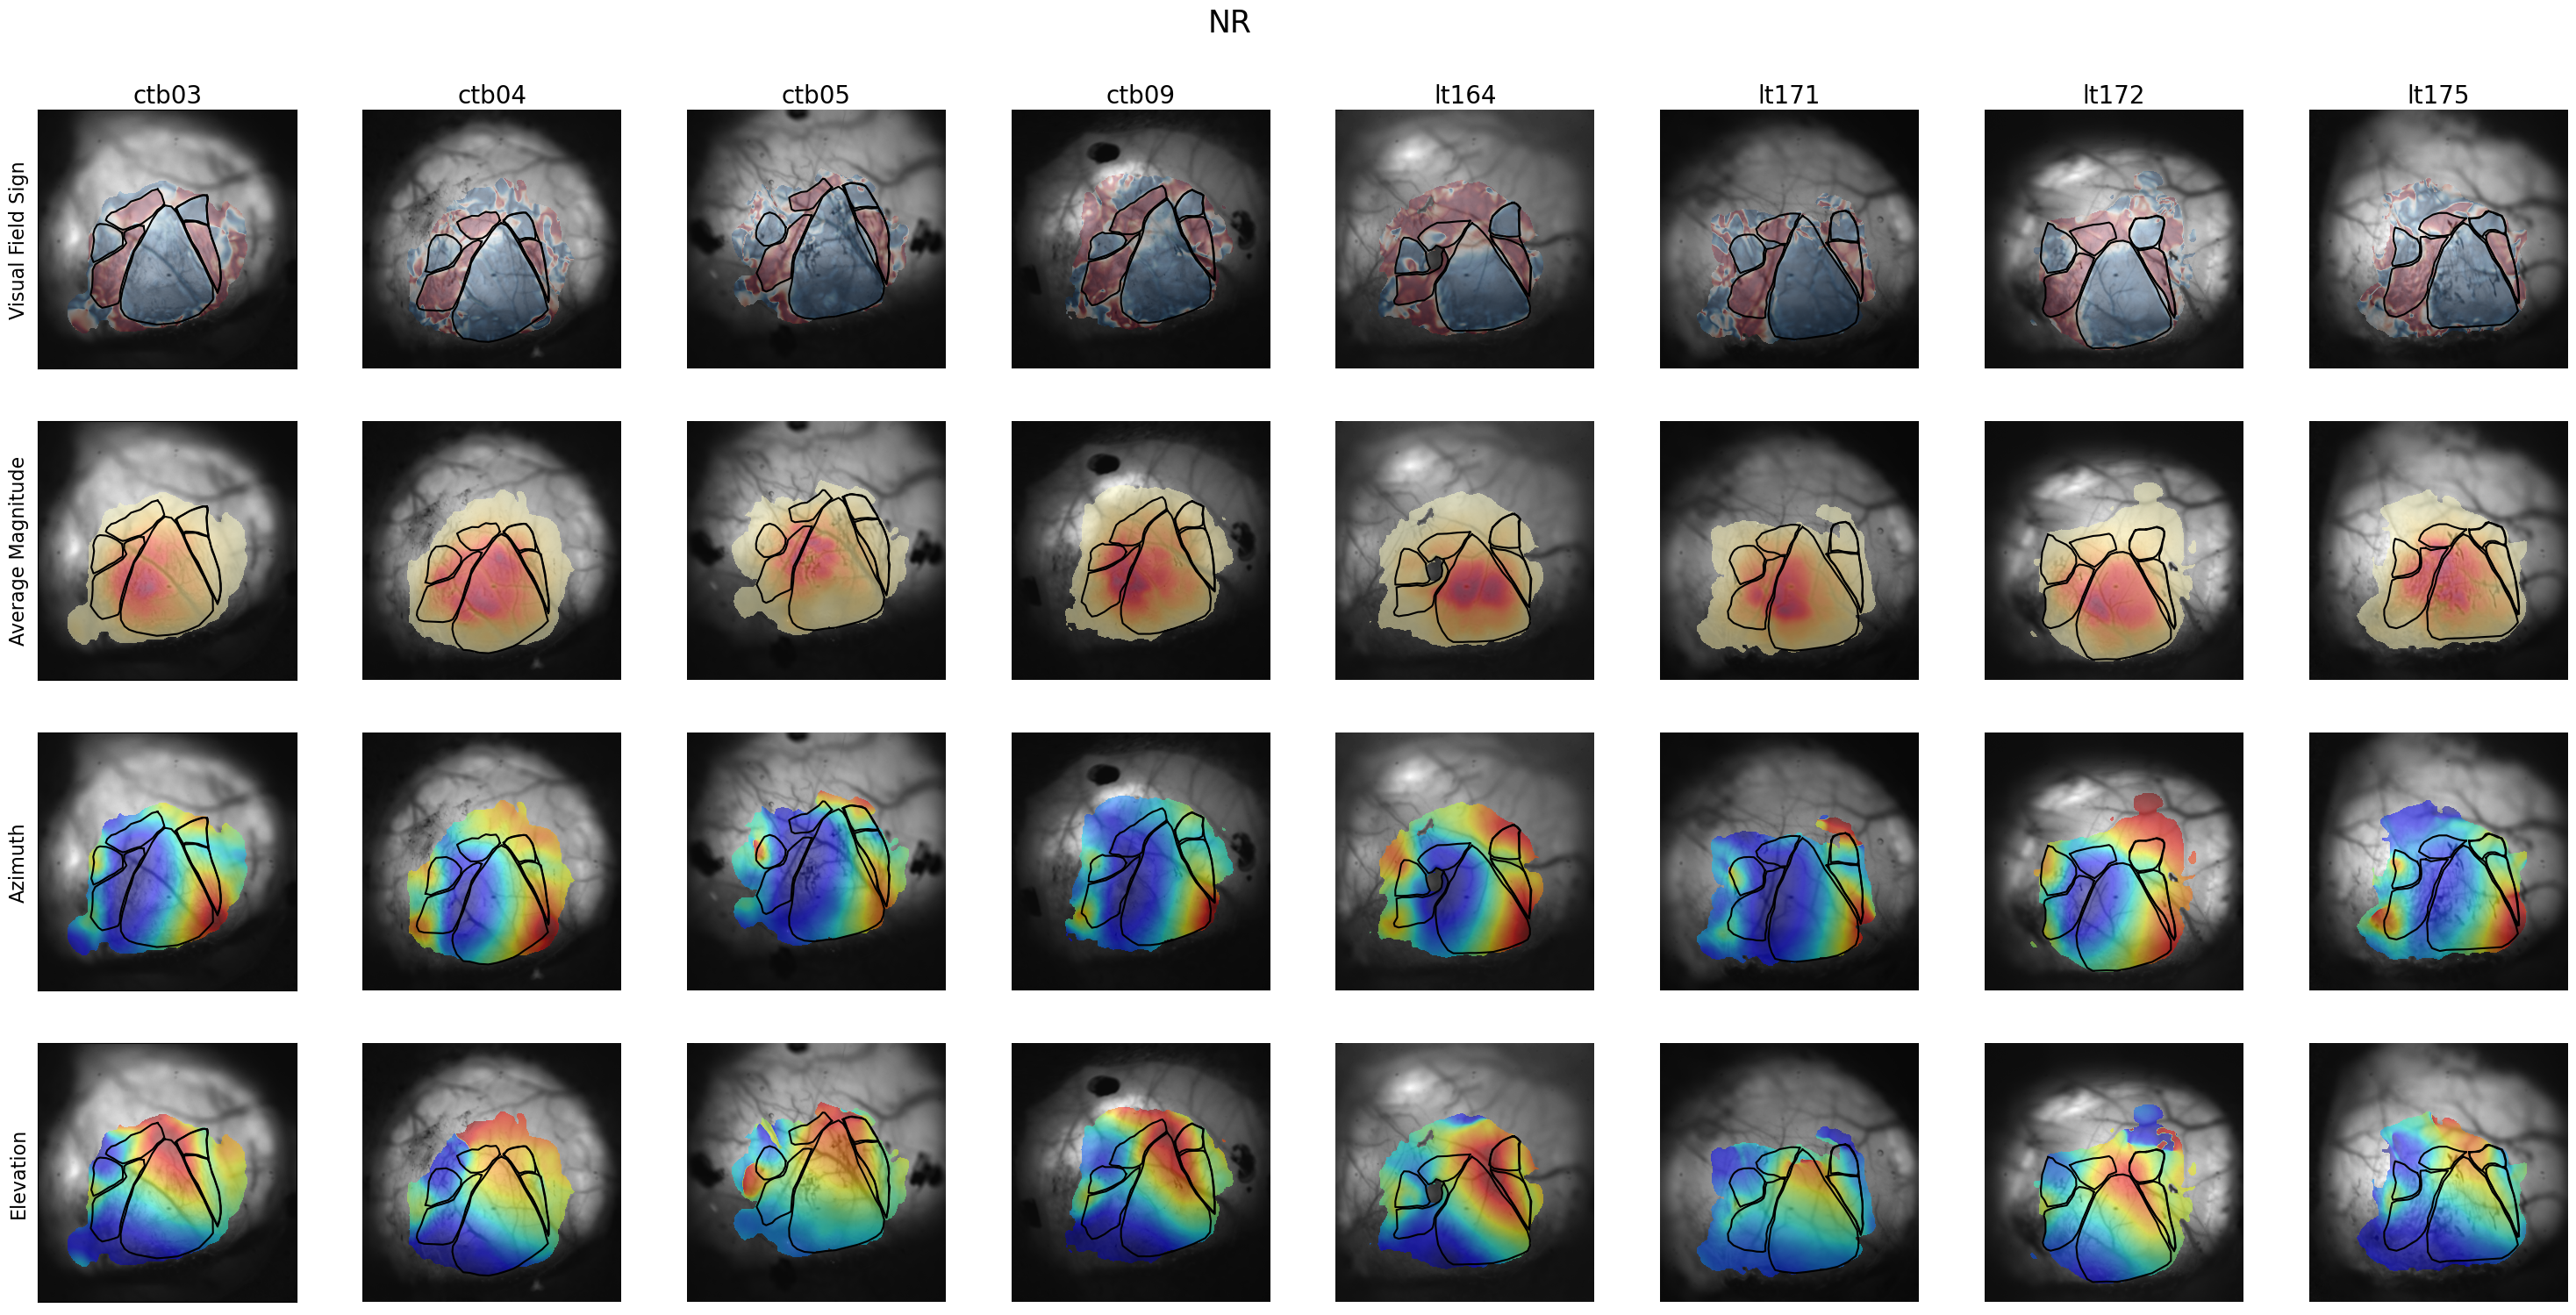

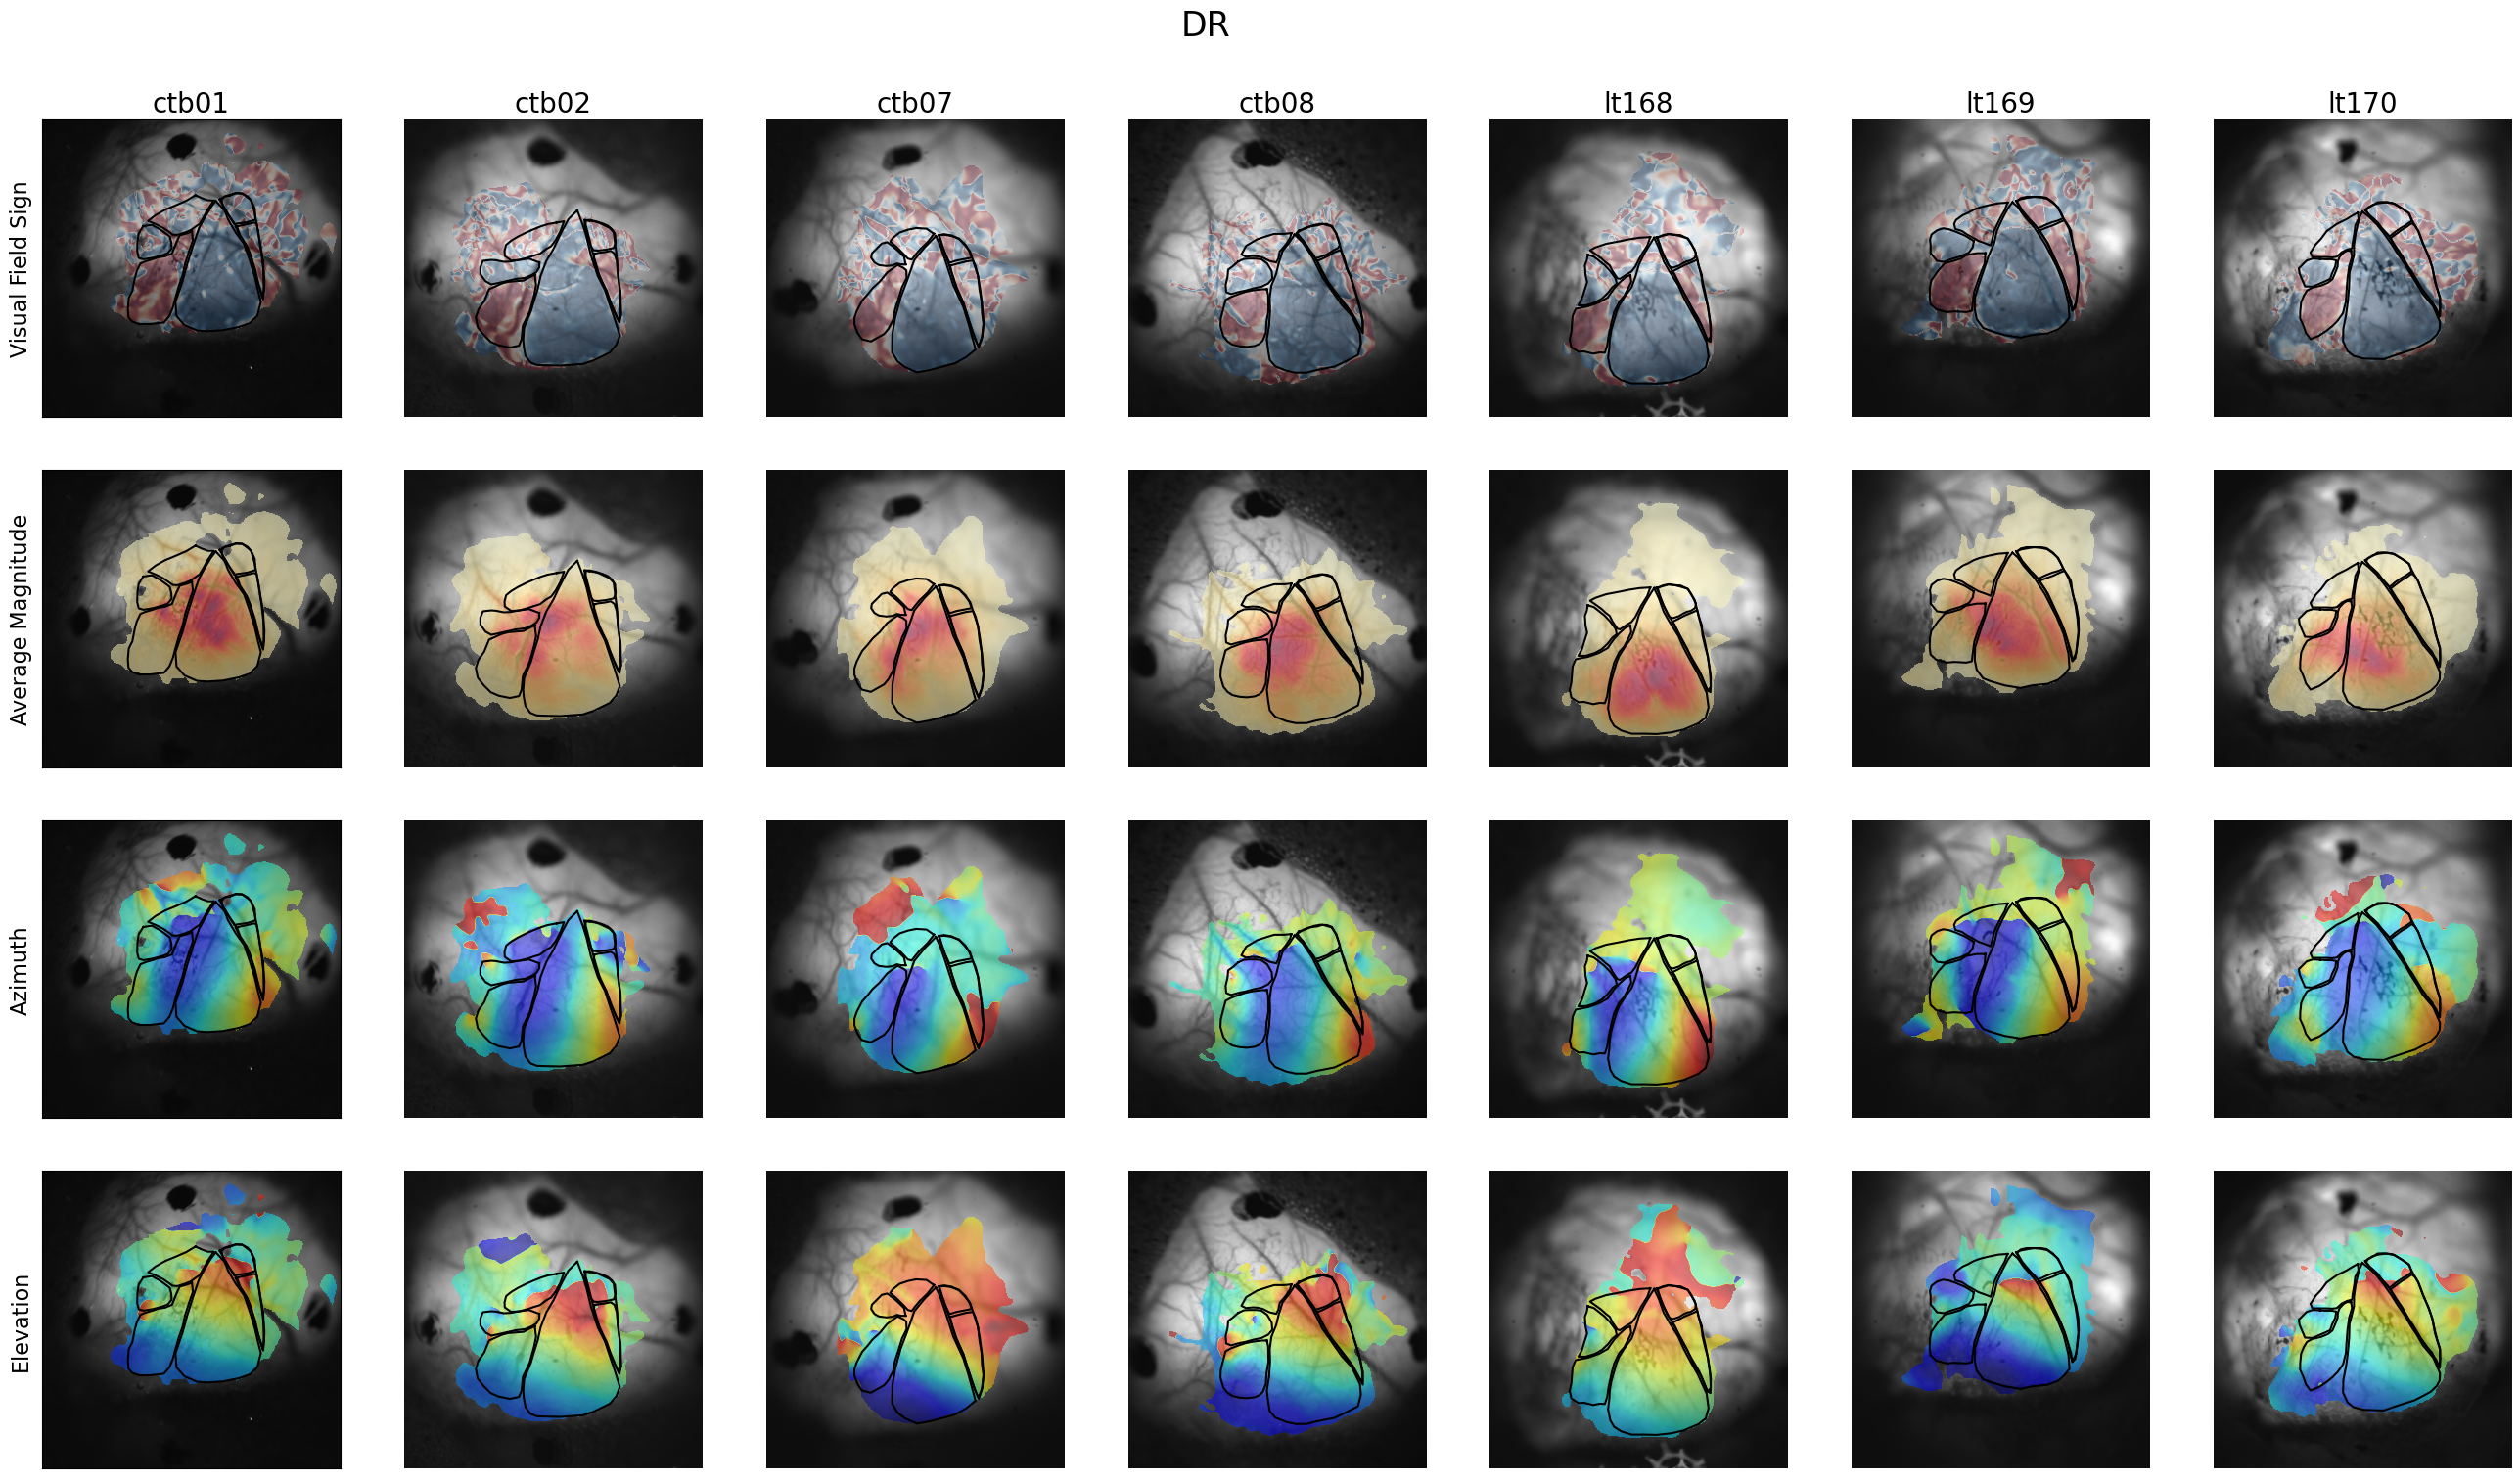

In [24]:
# Split exp_info into NR and DR groups.
%matplotlib inline
for condition in zip(["NR", "DR"], (8, 7), (32, 28)):
    fig, axs = plt.subplots(4, condition[1])
    col = -1
    for ID,data in exp_info.items():
        if data["rearing"] == condition[0]:
            col += 1
            # Sign map
            axs[0][col].imshow(data["refframe"], cmap="gray")
            axs[0][col].imshow(data["signmap"], cmap="RdBu_r", clim=[-1,1], alpha=0.3)
            axs[0][col].axis("off")
            axs[0][col].set_title(ID, fontsize=20)
            # Average magnitude
            axs[1][col].imshow(data["refframe"], cmap="gray")
            axs[1][col].imshow(data["avg_mag"], cmap="YlOrRd", alpha=0.5)
            axs[1][col].axis("off")
            # Azimuth
            axs[2][col].imshow(data["refframe"], cmap="gray")
            axs[2][col].imshow(data["azimuth"], cmap="jet_r", alpha=0.5)
            axs[2][col].axis("off")
            # Elevation
            axs[3][col].imshow(data["refframe"], cmap="gray")
            axs[3][col].imshow(data["elevation"], cmap="jet_r", alpha=0.5)
            axs[3][col].axis("off")
            # Area boundaries
            for area in area_list:
                for plot_num in range(4):
                    axs[plot_num][col].plot(data["area_coords"][area][:,0], data["area_coords"][area][:,1], color="k")
            # Row labels
            if col == 0:
                for lbl_num,lbl in enumerate(["Visual Field Sign", "Average Magnitude", "Azimuth", "Elevation"]):
                    axs[lbl_num][col].axis("on")
                    axs[lbl_num][col].set_xticks([])
                    axs[lbl_num][col].set_xticklabels([])
                    axs[lbl_num][col].set_yticks([])
                    axs[lbl_num][col].set_yticklabels([])
                    axs[lbl_num][col].set_ylabel(lbl, fontsize=16)
                    
    # Set figure parameters.
    fig.tight_layout(rect=[0, 0, 1, 1])
    fig.set_size_inches(condition[2], 16)
    fig.suptitle(condition[0], fontsize=25)
    fig.savefig(data_path + condition[0] + ".png", bbox_inches="tight")

Calculate Average Magnitude and Scatter for each Segmented Visual Area